#### Compute cyclone center density while also taking into accountace the grid points between two storm centers :
See file *methods* for more information (see Maxine Cloutier-Gervais)

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4

# matplotlib import
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# cartopy import
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

# scipy import
from scipy.interpolate import griddata
from scipy.ndimage import convolve

In [3]:
def add_features():
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none', edgecolor='black', zorder=6)
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='lightgray', zorder=4)
    
    lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='black', facecolor='none', zorder=7)
    
    lakes_50m_edge= cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='black',
                                            facecolor='None',lw=1.2, zorder=9)

    ax.add_feature(land_50m)    
    ax.add_feature(lakes_50m)
    ax.add_feature(lakes_50m_edge)
    ax.add_feature(cfeature.BORDERS, zorder=6, edgecolor='black')  
    ax.add_feature(states_provinces)
    ax.coastlines('50m', zorder=7, color='black',lw=1.2)

In [4]:
def circ_krnl(radius) : 
    
    """
    
    Create a kernel (matrix). 
    (0,0) is the pixel of interest
    if (i,j) = 1, the pixel is at r distance from (0,0)
    if (i,j) = 0, the pixel is further.
    
    """
    
    # x, y : horizontal (vertical) 1D array with values from -9 to 9
    y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
    
    # get rid of negative values and get pixels that are within the 
    # radius distance of (0,0)
    mask = x**2 + y**2 <= radius **2
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    
    # Assign 1 to pixel if mask == True and 0 if False
    kernel[~mask] = 0
    return kernel

def circ_filt(array, radius) : 
    
    """
    
    Use convolve scipy function to calculate the average value
    of a pixel around a given radius (creates circular smoothing)
    
    """
    
    kernel = circ_krnl(radius)
    
    # normalize the kernel
    n_krnl = kernel / np.sum(kernel) 
    
    return convolve(array, n_krnl)

plotting for ...  JJA
plotting for ...  SON
plotting for ...  DJF
plotting for ...  MAM


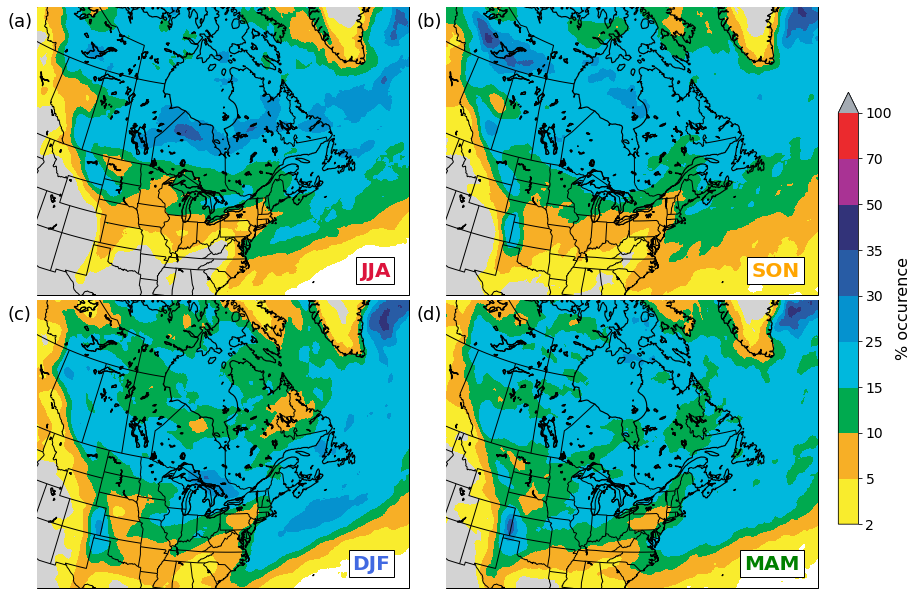

In [32]:
# Import track density 
Track=netCDF4.Dataset('/pampa/cloutier/density/NAEC/Track_density_1979_2020_all_seasons.nc','r')

# create lists for iteration
seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['crimson', 'orange', 'royalblue', 'green']
index = ['(a)', '(b)', '(c)', '(d)']

r = 4
i = 1
fig = plt.figure(figsize = (14, 12))
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])
extent = (-110, -50, 27.5, 67.3)
colors_cmap = ['#F9EC2D', '#F7AF26', '#00AA4F', '#00B8DD', '#0592CF', 
               '#285CA5', '#323379', '#A93394', '#EB2A2E', '#A4ABB3']

for szn, col, idx in zip(seasons, colors, index) : 
    lat0 = Track.variables['latitude'][:]
    lon0 = Track.variables['longitude'][:]
    den = Track.variables['trackDen_'+szn+''][:,:] 
    
    lon, lat = np.meshgrid(lon0, lat0)
    
    # create sub figures
    ax = fig.add_subplot(2, 2, i, projection=proj)
    i += 1
    extent=(-110, -50, 27.5, 67.3)
    add_features()
    ax.set_extent(extent)

    # Number of tracks per 1000km2
    den_area = (den * (1000**2)) / (np.cos(np.radians(lat)) * (111.3 * 0.25)**2)
    season_tot = den[den >0].size # total of grid points for the season
    den_freq = (den_area / season_tot) * 100
    
    # Add circular averaging 
    den_filt = circ_filt(den_freq, r)
    
    levels = [2, 5, 10, 15, 25, 30, 35, 50, 70, 100]
    print('plotting for ... ', szn)
    contour = ax.contourf(lon, lat, den_filt, transform=ccrs.PlateCarree(), 
                          zorder=5, colors=colors_cmap, levels=levels, extend='max')
    
    ax.spines['geo'].set_linewidth(1)
    
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=20, zorder=16, fontweight ='bold', color=col)
    
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=18)


# Create a colorbar next to the figure
# Value 1 : x coordinate (move left and right)
# value 2 : y coordinate (move up and down)
# Value 3 : Width 
# value 4 : height (in terms of % of the figure)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.5])  # Adjust the position and size as needed
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.set_label(label='% occurence', size=16)
cbar.ax.tick_params(labelsize=14)

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace = 0.1)
#fig.text(0.33, 0.85, 'Average track density per area of 1000 km$^{2}$', va='top', fontsize=16)

#plt.savefig('/pampa/cloutier/fig/cyclone_center_density_smooth_with_gp_between.png', dpi = 300)

plt.show()

Track.close()